In [55]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size= "6"> Abstract: </font>

In this blog post we will work to implement gradient descent for logistic regression in an object-oriented paradigm, set up a key variant of gradient descent which utilizes "momentum" in order to achieve faster convergence, and perform various experiments to exhibit the behavior or traditional gradient descent, the strength of momentum, and the dangers of overfitting. We hope that by the end of this post reader will have a better understanding or how the model functions and how we can utilize it.

I have attached below a link to my source code for the LogisticRegression and GradientDescentOptimizer classes. 

https://github.com/Astro2024/Astro2024.github.io/blob/main/posts/logistic-regression/logistic.py

<font size="6"> Part A: Implement Logistic Regression </font>

<font size="5"> LogisticRegression Class: </font>

<font size="4"> Sigma: </font> In order to implement our Logistic Regression model I first started by defining a function called sigma. This function allows our gradient decent to find a global minimum for the loss function.

In [235]:
import torch
def sigma(self, val):
        return 1 / (1 + torch.exp(-val))

<font size="4"> Loss: </font> After implementing the sigma function I created our loss function based off the equation 

$L(w) = \frac{1}{n} \sum_{i=1}^{n} [-y_i log(\sigma(s_i)) - (1 - y_i)log(1 - \sigma(s_i))]$.
Where our $s_i$ is the predicted score at a given index and $\sigma$ is the function defined above.

In [236]:
def loss(self, X, y):
        s = self.score(X)
        inner = (-1*y*torch.log(self.sigma(s))) - ((1 - y) *torch.log(1- self.sigma(s)))
        return (1/X.shape[0]) * inner.sum()

<font size="4"> Grad: </font> The last function we must define in the LogisticRegression class is "grad". The mathematical equation for this function is $L(w) = \frac{1}{n} \sum_{i=1}^{n} (\sigma(s_i) - y_i)x_i$. In the code below we take advantage of linear algebra operation to eliminate explicit sum functions.

In [237]:
def grad(self, X, y):
        s = self.score(X)
        summation = (self.sigma(s) - y)@X
        return (1/X.shape[0]) * summation

<font size="5"> GradientDescentOptimizer Class: </font>

<font size="4"> Step: </font> This function computes one step of the Logistic Regression update using the feature matrix X and target vector y. The mathematical equation for the update is, $w_{k+1} \leftarrow w_k - \alpha \triangledown L(w_K) + \beta(w_k - w_{k-1})$. Where $\alpha$ is our designated learning rate and $\beta$ is our momentum variable.

In [239]:
def step(self, X, y, alpha, beta):
        temp = torch.clone(self.model.w)
        new_w = alpha*self.model.grad(X,y) - beta*(self.model.w - self.model.w1)
        self.model.w1 = temp
        self.model.w -= new_w

<font size="6"> Part B: Experiments </font>

The following block of code defines a function that generates random data we will use for data classification. Using this function we can choose the number of data point, how many dimensions each data point has, and how "noisy" the data is (how easily separable it is).

In [63]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise=.5)

<font size="4"> Vanilla Gradient Descent: </font>

The following code is an example of why we use gradient descent optimization. Using 2 dimensional data, a sufficiently low alpha, and setting beta = 0 we can observe that our loss function is monotonically decreasing and looks like it is converging towards 0. This means as we do further iteration and optimization our loss will continue to get lower until it converges to a minimum loss.

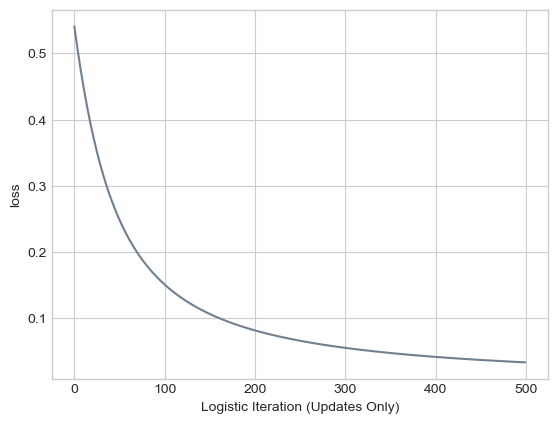

In [231]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1.0
# for keeping track of loss values
loss_vec = []

for _ in range(500):
    #Calculate loss and record improvement
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    #Update LR 
    opt.step(X, y, alpha = 0.1, beta = 0)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")


<font size="4"> Benefits of Momentum: </font>

In the example above we set our beta = 0 and saw that our loss function roughly followed a logarithmic curve. So what happens when we start to increase out beta value? Well, in not super technical terms we start to increase the "momentum" of the loss function. That is to say, by increasing beta it might take a little longer for the loss function to start decreasing, but once it does the rate of decrease is significantly higher. Below is an example of the use of the "beta" variable in the step function. Using the same data and learning rate we look at the difference between loss function with beta = 0 (no momentum) and one with beta= .8 (momentum). We can set that the function with momentum breaks our loss threshold (.05) in fewer iteration than the function with no momentum.

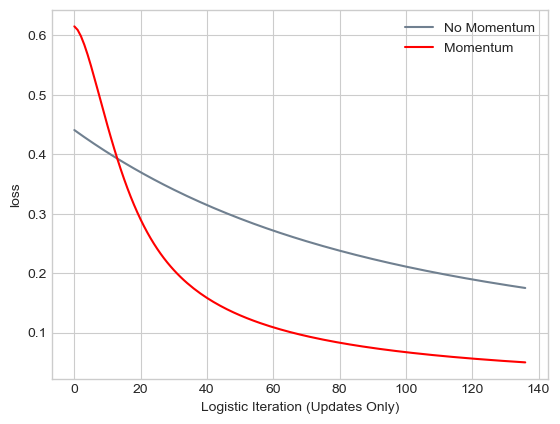

In [233]:
X, y = classification_data(n_points=100, noise=.25, p_dims=10)
#Initialize two Logistic Regression functions
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
LR1 = LogisticRegression() 
opt1 = GradientDescentOptimizer(LR1)
#Initialize lass for two functions
loss = 1.0
loss_vec = []
loss1 = 1.0
loss_vec1 = []

#Iterate until the momentum model is under threshold
while loss1 > .05:
    #Calculate and record losses
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    loss1 = LR1.loss(X, y) 
    loss_vec1.append(loss1)

    # Optimize model 1 with no momentum, and model 2 with momentum
    opt.step(X, y, alpha = 0.05, beta = 0)
    opt1.step(X, y, alpha = 0.05, beta = 0.8)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey", label="No Momentum")
plt.plot(loss_vec1, color = "red", label="Momentum")
plt.legend()
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")

<font size="4"> Overfitting: </font>

In the code below we experience a phenomenon called overfitting. It is where we train the model so specifically and repetitively on a training set that it can no longer make accurate predictions about any data other than the training set. Using two sets of similar data where the dimensionality of our data is higher than the number of data points in our data set we first train a model on our training data. Since there are more dimensions than data points both the training and test data is linearly separable, however due to the high dimensionality, when we train the data our model only becomes able to predict the specific data in the training set. This is shown below. Even though the size of our data is relatively small due to high weight values and rounding errors, you can see that while the model is 100% accurate on the training data it is only 75% accurate on the testing data.

Training Accuracy: 1.0
Testing Accuracy: 0.75


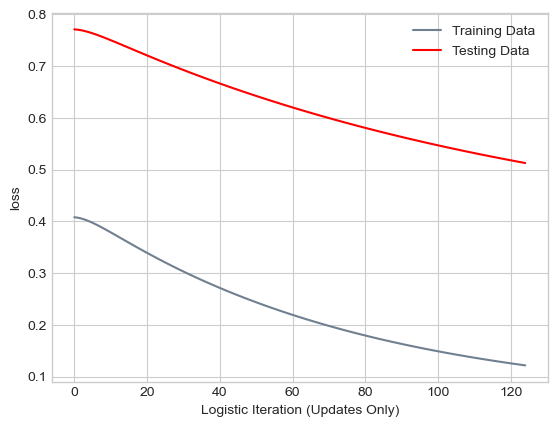

In [234]:
#Initialize training and testing data
X_train, y_train = classification_data(n_points=20, noise=.7, p_dims=25)
X_test, y_test = classification_data(n_points=20, noise=.7, p_dims=25)

#Initialize model
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = 1.0
# for keeping track of loss values
loss_vec = []
loss_vec_test = []

count = 0
acc = 0

#Iterate until 100% accuracy on training data or 500 iterations
while acc < 1 and count < 500:
    count +=1

    #Calculate accuracy of model on training data
    pred = LR.predict(X_train)
    mcount = torch.sum(y_train == pred).item()
    acc = mcount/len(pred)
    
    #Calculate and record loss of each model
    loss = LR.loss(X_train, y_train) 
    loss_vec.append(loss)
    loss1 = LR.loss(X_test, y_test) 
    loss_vec_test.append(loss1)

    # Optimize on the training data
    opt.step(X_train, y_train, alpha = 0.01, beta = 0.8)


#Print the training accuracy
print("Training Accuracy: " + str(acc))
pred = (torch.matmul(X_test, LR.w) > 0).int()
mcount = torch.sum(y_test == pred).item()
perc = (mcount / len(pred))
print("Testing Accuracy: " + str(perc))

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey", label="Training Data")
plt.plot(loss_vec_test, color = "red", label="Testing Data")
plt.legend()
labs = plt.gca().set(xlabel = "Logistic Iteration (Updates Only)", ylabel = "loss")


<font size= "6"> Conclusion: </font>

Above we have implemented our logistic regression and gradient descent optimization classes so that we now have a working logistic regression model. With this implementation we have also explored how different forms of data and different parameters for our optimization can lead to various different results. For example, data with less noise is easier to minimize loss on and more likely to be linearly separable, momentum can be used in our optimization functions to decrease the number of iterations needed to converge on the "correct" weight vectors, and that even if the data is linearly separable, if our dimensionality is too high then we will induce overfitting on the training set and our models accuracy will decrease for outside data.
